In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from highlight_text import htext
from PIL import Image
import os
import math

Useful function reset matplotlib parameters before creating a new figure

In [2]:
def reset_matplotlib():
    plt.rcParams.update(plt.rcParamsDefault)

Get back to the root of the ipl_vizs repo

In [3]:
root_path = '/'.join(os.getcwd().split('/')[:-1])

Define some key plotting parameters which we will use again and again, mainly around fonts and styling

In [4]:
title_font = 'Din Alternate'
main_font = "Gill Sans"
text_colour = 'w'
outline_colour = 'w'
background_colour =  '#96afd9'
title_font_size = 20
subtitle_font_size = 10
logo_path = root_path + '/images/logo.png'

Open team_info xls, holds lots of information like colour codes for the individual teams

We create a dictionary with keys as the team names so we can look up other features if we need them

In [5]:
team_info = pd.read_excel(root_path+ '/team_data/team_info.xlsx')
team_info = team_info.set_index('team').to_dict()

Open up all the files in the folder, i.e. all the ball by ball data we have and concat into one dataframe

In [6]:
all_data_lst = []
ball_folder_path = root_path+'/ball_by_ball_data/ipl/'

for filename in os.listdir(ball_folder_path):
    df = pd.read_csv(ball_folder_path+filename)
    all_data_lst.append(df)

bb = pd.concat(all_data_lst)

In [7]:
all_match_info = []
match_info_folder_path = root_path+'/match_info_data/ipl/'

for filename in os.listdir(match_info_folder_path):
    df = pd.read_csv(match_info_folder_path+filename)
    all_match_info.append(df)

mi = pd.concat(all_match_info)

In [9]:
squads_folder_path = root_path+'/team_data/ipl_squads.csv'
squads = pd.read_csv(squads_folder_path)
squads= squads.loc[squads['year'] == 2021]
squads = squads.set_index('name').to_dict()

In [24]:
df = bb.merge(mi, how='inner', on='match_id')

In [25]:
df['team_two'].value_counts()

Royal Challengers Bangalore    22758
Kolkata Knight Riders          22635
Kings XI Punjab                22174
Mumbai Indians                 21798
Rajasthan Royals               21270
Delhi Daredevils               20952
Chennai Super Kings            19452
Sunrisers Hyderabad            13102
Deccan Chargers                 7487
Pune Warriors                   6141
Delhi Capitals                  3883
Gujarat Lions                   3802
Rising Pune Supergiant          1868
Kochi Tuskers Kerala            1546
Rising Pune Supergiants         1386
Name: team_two, dtype: int64

Brief bit of data cleaning to replace the Rising Pune Supergiant values

In [26]:
for col in ['team', 'team_one', 'team_two']:
    df[col] = np.where(df[col]=='Rising Pune Supergiant', 'Rising Pune Supergiants', df[col])
    df[col] = np.where(df[col]=='Delhi Daredevils', 'Delhi Capitals', df[col])

To get the team the bowler was playing for, we need to take the batting team, compare it to the two teams from the match info and take the other one

In [27]:
df['fielding_team'] = np.where(df['team'] == df['team_one'], df['team_two'], df['team_one'])

All we need on each player is their name, the match_id (so we don't count bowling and batting in the same game as playing twice), the team they represented and then the date to sort them chronologically

In [28]:
batters = df[['batter','match_id','team','date']]
nonstrikers = df[['nonstriker','match_id','team','date']]
bowlers = df[['bowler','match_id','fielding_team','date']]

In [29]:
cols = ['player','match_id','team','date']
frames = [batters, nonstrikers, bowlers]

for dataframe in frames:
    dataframe.columns = cols

In [30]:
df = pd.concat(frames)

In [31]:
appearances = df.groupby(['player','match_id','team','date']).count()
appearances.reset_index(inplace=True)

In [32]:
total = appearances.groupby('player')['match_id'].nunique()
appearances['total'] = appearances['player'].map(total)

In [33]:
appearances.sort_values(['total','player','date'], ascending=[False, True, True], inplace=True)

Create a column of the team's colour so we can colour the bars accordingly

In [34]:
appearances['colour'] = appearances['team'].apply(lambda x: team_info['primary_colour'].get(x))

In [35]:
appearances['2021_team'] = appearances['player'].apply(lambda x: squads['team'].get(x))

Create a name column which we will use for the labels, we replace the first occurence of a space with \n to drop it onto 2 lines

Some common styling we can wrap up in a function to make it repeatable

In [36]:
def format_vt20_graphs(fig, ax):
    fig.set_facecolor(background_colour)
    ax.patch.set_facecolor(background_colour)
    plt.xticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    plt.yticks(c=text_colour, fontfamily=main_font, fontsize=8, fontweight='bold')
    ax.tick_params(axis='both', colors=text_colour)
    spines = ["top","right","bottom","left"]
    for s in spines:
        if s in ["top","right"]:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    return fig, ax

We plot the top 12 most capped players in the history of the IPL competition

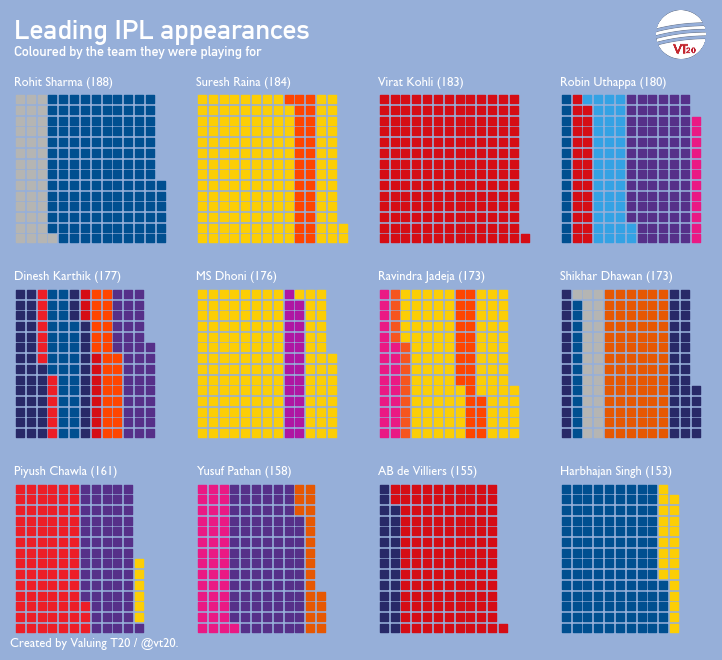

In [38]:
reset_matplotlib()
n_players = 12

max_n = appearances['total'].max()
sqroot = math.ceil(math.sqrt(max_n))
# math.ceil(math.sqrt(apps['total'].max()))

players = appearances['player'].unique()[0:n_players]
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9,7))

fig.set_facecolor(background_colour)

counter = 0

for i in range(0,3):
    for j in range(0,4):
        player = players[counter]
        _df = appearances.loc[appearances['player'] == player]
        games = _df['total'].max()
        a = ax[i,j]
        n = 1
        for x in range(1,sqroot+1):
            for y in range(1,sqroot+1):
                if n > games:
                    break
                # print(n)
                row = _df.iloc[n-1]
                team = row['team']
                colour = row['colour']
                n+=1
                a.scatter(x,y,marker='s',c=colour, edgecolor=colour)
                a.set_title(f'{player} ({games})', c=text_colour, fontsize=9, loc='left', fontfamily=main_font)
                
        # a.axis('square')
        a.set_xlim([0.5,sqroot+0.5]) 
        a.set_ylim([0.5,sqroot+0.5])
        a.axis('off')
        counter +=1 
        
plt.subplots_adjust(hspace=0.3)

htext.fig_text(x = 0.125, y = 0.95,
                    s = f'Leading IPL appearances'
                    , color = text_colour
                    , fontsize=title_font_size
                    , fontfamily=title_font
                    , fontweight='bold')

htext.fig_text(x = 0.125, y = 0.93,
                        s = f'Appearances oloured by the team they were playing for'
                        , color = text_colour
                        , fontsize=subtitle_font_size
                        , fontfamily=title_font
                        , fontstyle='italic')

ax2 = fig.add_axes([0.83,0.93,0.07,0.07]) # badge
ax2.axis("off")
img = Image.open(logo_path)
ax2.imshow(img)

fig.text(0.12, 0.09, "Created by Valuing T20 / @vt20.",
        fontstyle="italic",fontsize=9, fontfamily=main_font, color=text_colour)

fig.savefig(root_path + f'/outputs/total_appearances/all_time.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches = 'tight')

plt.show()

Now we can iterate through the teams playing in IPL 2021. Find the players in each squad and sort them by the number of caps they've won.

This gives the 12 most experienced players for each IPL franchise in the 2021 competition.

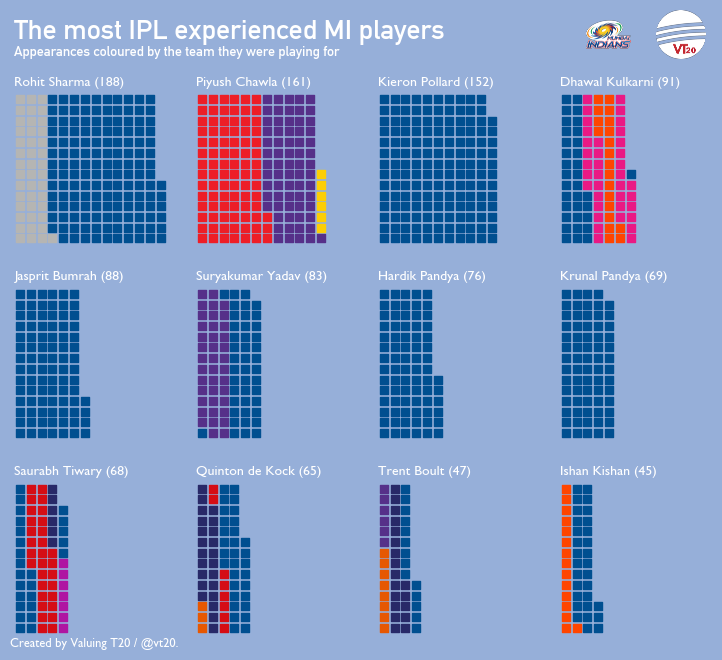

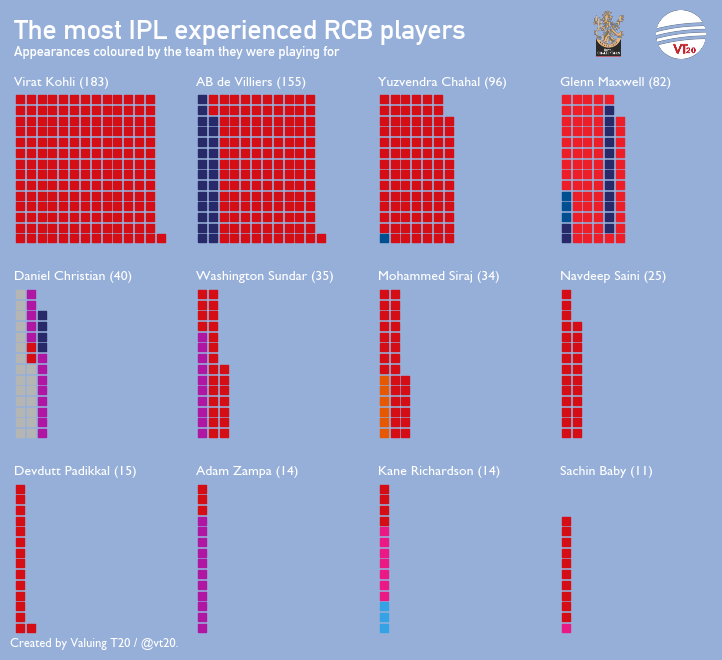

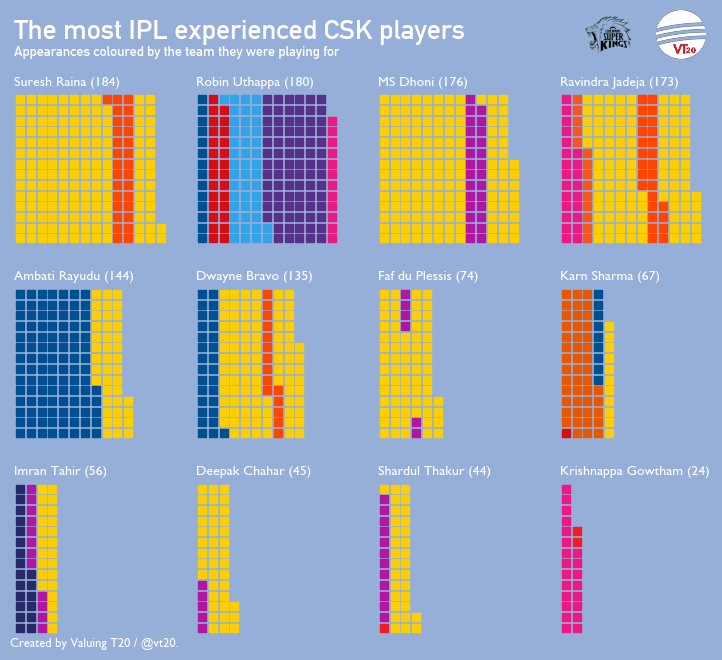

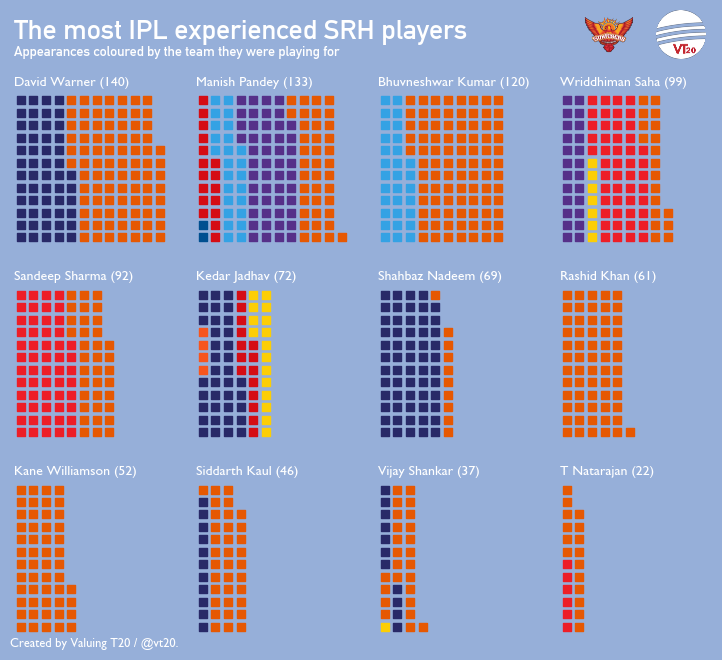

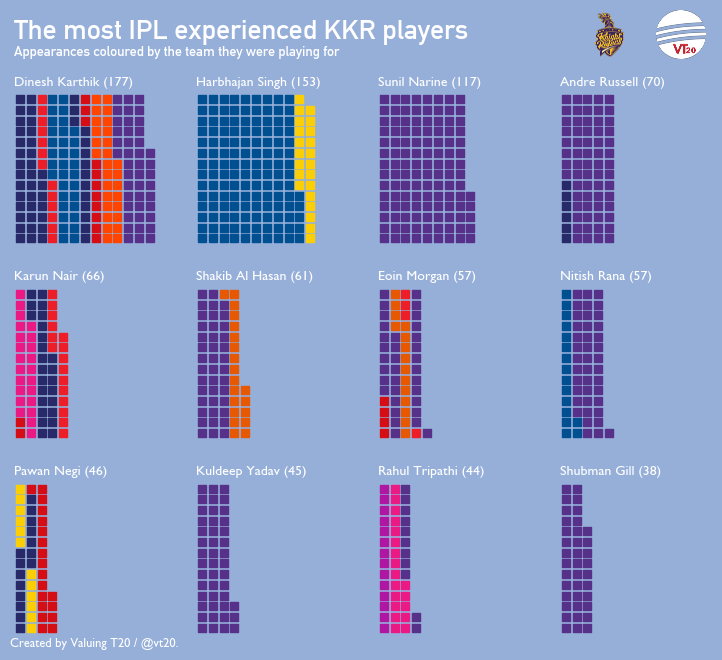

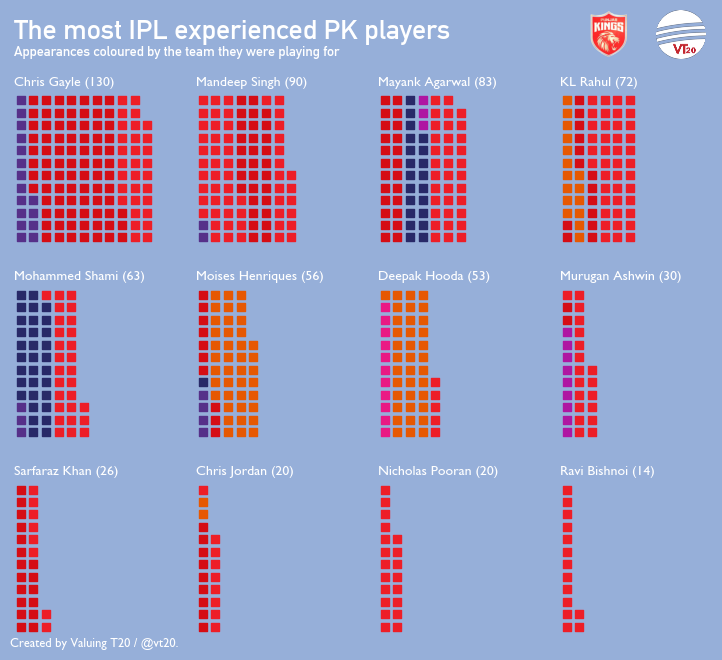

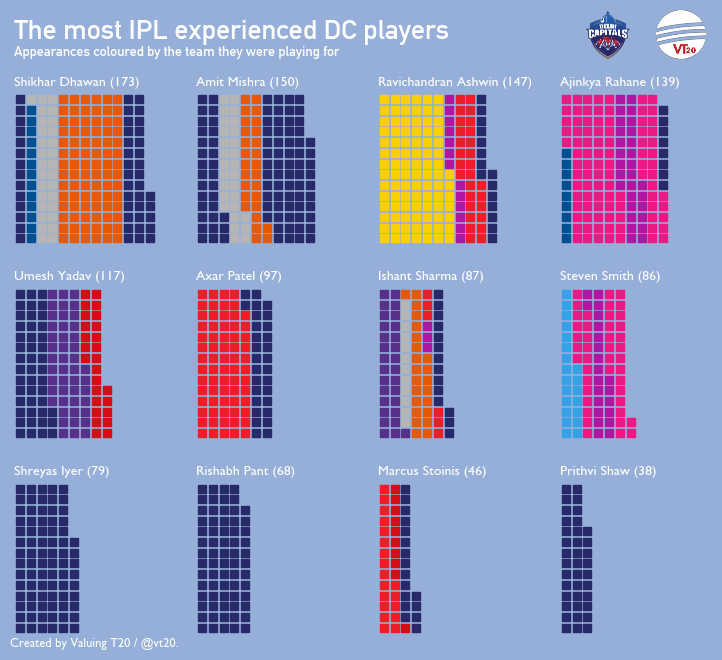

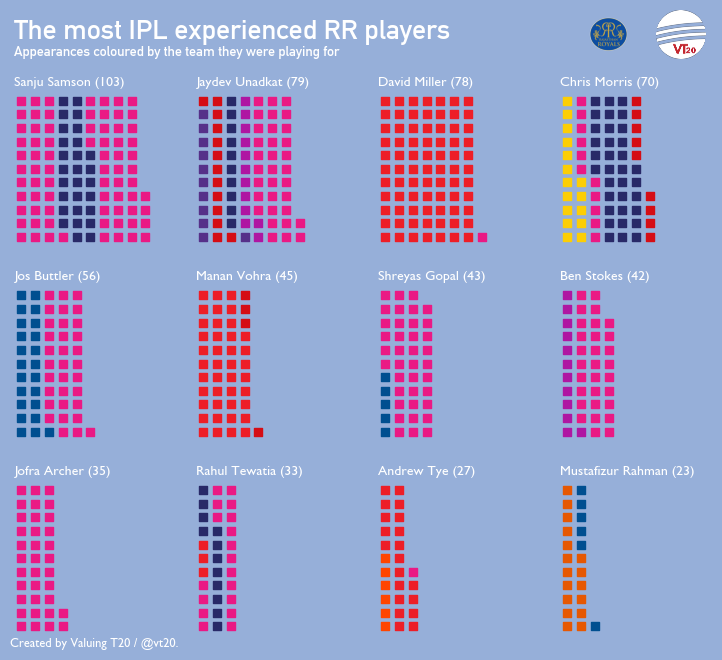

In [49]:
for team in list(set((squads['team'].values()))):

    reset_matplotlib()

    team_lower = team.lower().replace(' ','_')

# Find where the team's logo is stored
    image_path = root_path + '/images/team_logos/ipl/' + team_lower + '.png'

    teamdf = appearances.loc[appearances['2021_team'] == team]
    team_code = team_info['code'].get(team)

# Highest number of caps for anyone player in the team
    max_n = teamdf['total'].max()

# If we have the highest number of caps being 140, we want to have a 12x12 grid (max number of caps 144)
    sqroot = math.ceil(math.sqrt(max_n))
    # math.ceil(math.sqrt(apps['total'].max()))
    n_players = 12
    players = teamdf['player'].unique()[0:n_players]
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9,7))

    fig.set_facecolor(background_colour)

    counter = 0

    for i in range(0,3):
        for j in range(0,4):
            player = players[counter]
            _df = appearances.loc[appearances['player'] == player]
            games = _df['total'].max()
            a = ax[i,j]
            n = 1
            for x in range(1,sqroot+1):
                for y in range(1,sqroot+1):
                    if n > games:
                        break
                    # print(n)
                    row = _df.iloc[n-1]
                    team = row['team']
                    colour = row['colour']
                    n+=1
                    a.scatter(x,y,marker='s',c=colour, edgecolor=colour)
                    a.set_title(f'{player} ({games})', c=text_colour, fontsize=10, loc='left', fontfamily=main_font)
            a.set_xlim([0.5,sqroot+0.5]) 
            a.set_ylim([0.5,sqroot+0.5])     

            # a.axis('square')
            a.axis('off')
            counter +=1 
            
    plt.subplots_adjust(hspace=0.3)

    htext.fig_text(x = 0.125, y = 0.95,
                        s = f'The most IPL experienced {team_code} players'
                        , color = text_colour
                        , fontsize=title_font_size
                        , fontfamily=title_font
                        , fontweight='bold')

    htext.fig_text(x = 0.125, y = 0.93,
                            s = f'Appearances coloured by the team they were playing for'
                            , color = text_colour
                            , fontsize=subtitle_font_size
                            , fontfamily=title_font
                            , fontstyle='italic')

    ax2 = fig.add_axes([0.83,0.93,0.07,0.07]) # vt20 logo
    ax2.axis("off")
    img = Image.open(logo_path)
    ax2.imshow(img)

# Plot the team's logo alongside the VT20 logo
    ax3 = fig.add_axes([0.75,0.93,0.07,0.07]) # badge
    ax3.axis("off")
    img = Image.open(image_path)
    ax3.imshow(img)

    fig.text(0.12, 0.09, "Created by Valuing T20 / @vt20.",
            fontstyle="italic",fontsize=9, fontfamily=main_font, color=text_colour)

    fig.savefig(root_path + f'/outputs/total_appearances/{team_lower}.jpg', facecolor=fig.get_facecolor(), dpi=500, bbox_inches = 'tight')

    plt.close(fig)